In [15]:
import xml.etree.ElementTree as ET
import numpy as np, re
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


In [16]:
xml_path = "drive/MyDrive/assignment/O-A0038-003.xml"
tree = ET.parse(xml_path)
root = tree.getroot()
ns = {'ns': 'urn:cwa:gov:tw:cwacommon:0.1'}
content_elem = root.find('.//ns:Content', ns)
vals = [float(t) for t in re.split(r'[,\s]+', content_elem.text.strip()) if t != '']

n_cols, n_rows = 67, 120
arr = np.array(vals).reshape((n_rows, n_cols))
lon0, lat0, res = 120.00, 21.88, 0.03

records = []
for i in range(n_rows):
    for j in range(n_cols):
        lon = lon0 + j * res
        lat = lat0 + i * res
        v = arr[i, j]
        label = 0 if v <= -900 else 1
        records.append((lon, lat, v, label))
data = np.array(records, dtype=float)

# scaling
scaler = StandardScaler()
scaler.fit(data[:, :2])
clf_coords = scaler.transform(data[:, :2])
clf_labels = data[:, 3].astype(int)
mask_valid = data[:, 3] == 1
reg_coords = scaler.transform(data[mask_valid, :2])
reg_values = data[mask_valid, 2]

In [17]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 10), nn.ReLU(),
            nn.Linear(10, 16), nn.ReLU(),
            nn.Linear(16, 10), nn.ReLU(),
            nn.Linear(10, 2)
        )
    def forward(self, x): return self.net(x)

class ClfDataset(Dataset):
    def __init__(self, X, y):
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

clf_ds = ClfDataset(clf_coords, clf_labels)
n = len(clf_ds)
ntr = int(0.8*n)
clf_tr, clf_val = random_split(clf_ds, [ntr, n-ntr])
train_loader = DataLoader(clf_tr, batch_size=512, shuffle=True)
val_loader = DataLoader(clf_val, batch_size=512)

clf_model = Classifier().to(device)
clf_opt = optim.Adam(clf_model.parameters(), lr=1e-3)
clf_loss = nn.CrossEntropyLoss()

best_val, patience, no_imp = 0, 15, 0
for epoch in range(1, 2001):
    clf_model.train()
    tr_correct, tr_total = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        clf_opt.zero_grad()
        out = clf_model(xb)
        loss = clf_loss(out, yb)
        loss.backward()
        clf_opt.step()
        tr_correct += (out.argmax(1)==yb).sum().item()
        tr_total += len(yb)
    tr_acc = tr_correct/tr_total

    clf_model.eval()
    with torch.no_grad():
        val_correct, val_total = 0, 0
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = clf_model(xb)
            val_correct += (out.argmax(1)==yb).sum().item()
            val_total += len(yb)
    val_acc = val_correct/val_total
    if val_acc > best_val:
        best_val, no_imp = val_acc, 0
        torch.save(clf_model.state_dict(), "/tmp/best_clf.pt")
    else:
        no_imp += 1
    if epoch % 50 == 0 or epoch==1:
        print(f"Epoch {epoch:03d} | Train Acc={tr_acc:.3f} | Val Acc={val_acc:.3f}")
    if no_imp>=patience:
        print("Early stop at epoch", epoch)
        break

clf_model.load_state_dict(torch.load("/tmp/best_clf.pt"))
clf_model.eval()

Epoch 001 | Train Acc=0.438 | Val Acc=0.424
Epoch 050 | Train Acc=0.970 | Val Acc=0.979
Early stop at epoch 53


Classifier(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [18]:
class QDA:
    def fit(self, X, y):
        X = np.asarray(X); y = np.asarray(y).astype(int)
        X0, X1 = X[y==0], X[y==1]
        n0, n1 = len(X0), len(X1)
        self.mu0, self.mu1 = X0.mean(0), X1.mean(0)
        self.Sigma0 = np.cov(X0.T, bias=True)
        self.Sigma1 = np.cov(X1.T, bias=True)
        self.inv0 = np.linalg.pinv(self.Sigma0)
        self.inv1 = np.linalg.pinv(self.Sigma1)
        self.det0 = max(np.linalg.det(self.Sigma0), 1e-12)
        self.det1 = max(np.linalg.det(self.Sigma1), 1e-12)
        self.phi = n1 / (n0 + n1)
    def predict(self, X):
        X = np.asarray(X)
        d0 = X - self.mu0; d1 = X - self.mu1
        q0 = np.einsum("ij,jk,ik->i", d0, self.inv0, d0)
        q1 = np.einsum("ij,jk,ik->i", d1, self.inv1, d1)
        logp0 = -0.5*(np.log(self.det0)+q0)+np.log(1-self.phi+1e-12)
        logp1 = -0.5*(np.log(self.det1)+q1)+np.log(self.phi+1e-12)
        return (logp1>logp0).astype(int)

qda = QDA()
qda.fit(clf_coords, clf_labels)
y_pred_qda = qda.predict(clf_coords)
acc_qda = (y_pred_qda==clf_labels).mean()
print(f"QDA Full Acc={acc_qda:.4f}")
print("QDA Confusion:\n", confusion_matrix(clf_labels,y_pred_qda))

QDA Full Acc=0.8345
QDA Confusion:
 [[3977  568]
 [ 763 2732]]


In [19]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x): return self.net(x)

class RegDataset(Dataset):
    def __init__(self, X, y):
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

reg_ds = RegDataset(reg_coords, reg_values)
n = len(reg_ds)
ntr = int(0.8*n)
reg_tr, reg_val = random_split(reg_ds, [ntr, n-ntr])
train_r = DataLoader(reg_tr, batch_size=128, shuffle=True)
val_r = DataLoader(reg_val, batch_size=256)

reg_model = Regressor().to(device)
opt_r = optim.Adam(reg_model.parameters(), lr=1e-3)
loss_r = nn.MSELoss()

for epoch in range(1, 2001):
    reg_model.train()
    total_loss = 0
    for xb, yb in train_r:
        xb, yb = xb.to(device), yb.to(device)
        opt_r.zero_grad()
        out = reg_model(xb)
        loss = loss_r(out, yb)
        loss.backward(); opt_r.step()
        total_loss += loss.item()*xb.size(0)
    if epoch % 50 == 0:
        print(f"Reg Epoch {epoch}: loss={total_loss/len(train_r.dataset):.4f}")

reg_model.eval()
with torch.no_grad():
    preds_reg = reg_model(torch.tensor(reg_coords, dtype=torch.float32).to(device)).cpu().numpy().flatten()
rmse_reg = np.sqrt(mean_squared_error(reg_values, preds_reg))
print(f"Regression RMSE(valid)= {rmse_reg:.4f}")

Reg Epoch 50: loss=14.7353
Reg Epoch 100: loss=13.4550
Reg Epoch 150: loss=9.9125
Reg Epoch 200: loss=9.2262
Reg Epoch 250: loss=8.8917
Reg Epoch 300: loss=8.7206
Reg Epoch 350: loss=8.5989
Reg Epoch 400: loss=8.3995
Reg Epoch 450: loss=8.2944
Reg Epoch 500: loss=8.1181
Reg Epoch 550: loss=8.0201
Reg Epoch 600: loss=7.9146
Reg Epoch 650: loss=7.8587
Reg Epoch 700: loss=7.8465
Reg Epoch 750: loss=7.8323
Reg Epoch 800: loss=7.7553
Reg Epoch 850: loss=7.7422
Reg Epoch 900: loss=7.7231
Reg Epoch 950: loss=7.6884
Reg Epoch 1000: loss=7.6710
Reg Epoch 1050: loss=7.6535
Reg Epoch 1100: loss=7.6260
Reg Epoch 1150: loss=7.6476
Reg Epoch 1200: loss=7.5620
Reg Epoch 1250: loss=7.5617
Reg Epoch 1300: loss=7.5139
Reg Epoch 1350: loss=7.5697
Reg Epoch 1400: loss=7.4942
Reg Epoch 1450: loss=7.4855
Reg Epoch 1500: loss=7.4565
Reg Epoch 1550: loss=7.4660
Reg Epoch 1600: loss=7.4796
Reg Epoch 1650: loss=7.4391
Reg Epoch 1700: loss=7.4359
Reg Epoch 1750: loss=7.4693
Reg Epoch 1800: loss=7.4115
Reg Epoch 

In [20]:
def h_piecewise(X_scaled):
    X_t = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = clf_model(X_t)
        c_pred = torch.argmax(logits, dim=1).cpu().numpy()
    out = np.full(len(X_scaled), -999.0)
    idx = np.where(c_pred == 1)[0]
    if idx.size:
        with torch.no_grad():
            x_t = torch.tensor(X_scaled[idx], dtype=torch.float32).to(device)
            out[idx] = reg_model(x_t).cpu().numpy().flatten()
    return out, c_pred

coords_scaled = scaler.transform(data[:, :2])
h_all, c_all_nn = h_piecewise(coords_scaled)
c_all_qda = qda.predict(coords_scaled)

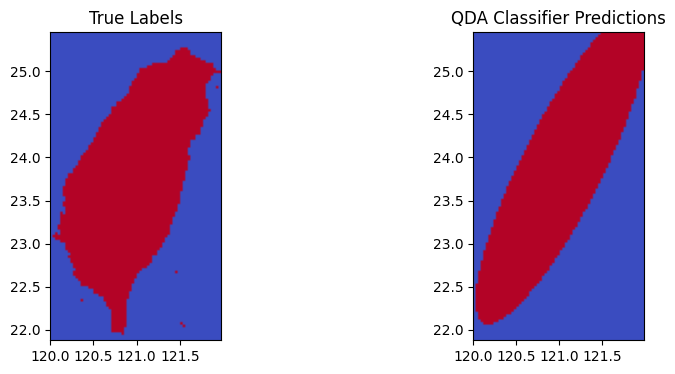

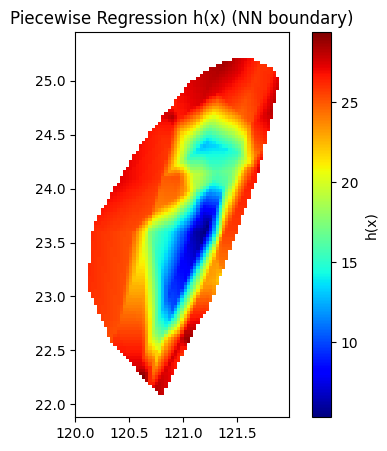

In [21]:
n_rows, n_cols = arr.shape
extent = [lon0, lon0+(n_cols-1)*res, lat0, lat0+(n_rows-1)*res]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(clf_labels.reshape(n_rows, n_cols), origin='lower', extent=extent, cmap='coolwarm', vmin=0,vmax=1)
plt.title("True Labels")

plt.subplot(1,2,2)
plt.imshow(c_all_qda.reshape(n_rows, n_cols), origin='lower', extent=extent, cmap='coolwarm', vmin=0,vmax=1)
plt.title("QDA Classifier Predictions")
plt.show()

# --- 第三張圖：h(x)
h_grid = h_all.reshape(n_rows, n_cols)
h_plot = np.where(h_grid==-999,np.nan,h_grid)
plt.figure(figsize=(6,5))
im = plt.imshow(h_plot, origin='lower', extent=extent, cmap='jet')
plt.colorbar(im,label="h(x)")
plt.title("Piecewise Regression h(x) (NN boundary)")
plt.show()